In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
from albumentations import IAAPerspective, Resize, Compose
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def orb(image1, image2, orb_size=500):
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(orb_size)
    keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2, None)
     
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
     
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
 
    # best 10%
    numGoodMatches = int(len(matches) * 0.1)
    matches = matches[:numGoodMatches]
     
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    return points1, points2


def rotate_images(image1, image2):
    """
    Rotate images according to the fixed points
    Returns:
        rotated_im - image1 rotated to fit image2
        h - transform matrix
    """
    # Get fixed points
    points1, points2 = orb(image1, image2)

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
    # Use homography
    height, width = image2.shape[:2] # channels are useless
    rotated_im = cv2.warpPerspective(image1, h, (width, height))

    return rotated_im, h
    
    
def generate_diff(img1, img2, mask1=None, mask2=None):
    rotated_im, h = rotate_images(img1, img2)
    height, width = img2.shape[:2]
    
    subtracted = cv2.subtract(img2, rotated_im)
    subtracted_back = cv2.subtract(rotated_im, img2)
    added = cv2.add(subtracted, subtracted_back)
    ret, th1 = cv2.threshold(rotated_im, 0, 255, cv2.THRESH_BINARY)
    added[np.where(th1 < 255)] = 0
    
    added = cv2.erode(added, (5,5), 7)
    added = cv2.dilate(added,(2,2),iterations = 4)
    added = np.expand_dims(added, axis=2)
    if mask1 is not None:
        rotated_mask = cv2.warpPerspective(mask1, h, (width, height))
        full_mask = (rotated_mask + mask2)/2
        full_mask = np.expand_dims(full_mask, axis=2)
        return added, full_mask
    return added

In [3]:
def augment(aug, image, mask):
    res = Compose(aug)(image=image, mask=mask)
    return res['image'] ,res['mask']


def thresh(intensity):
    return int(intensity < 230)*255


def watermark_with_transparency(image, new_object, input_size):
    width, height = image.size
    mask_width, mask_height = new_object.size
    
    position = random.randint(0,width - mask_width), random.randint(0,height - mask_height)

    mask = new_object.point(thresh)

    new_image = Image.new('L', (width, height))
    new_mask = Image.new('L', (width, height))
    
    new_mask.paste(mask, position)
    new_image.paste(image, (0,0))
    new_image.paste(new_object, position, mask=mask)

    new_image, new_mask = augment(
        [IAAPerspective(p=1), Resize(p=1, height=input_size[0], width=input_size[1])],
        np.array(new_image),
        np.array(new_mask)
    )
    
    return new_image, new_mask

In [4]:
def my_generator(img_dir, mask_dir, image_list, batch_size):
    
    ids_train_split = range(len(image_list))
    while True:
        random.shuffle(image_list)
        for start in range(0, len(image_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]
            
            for id in ids_train_batch:
                img_path = os.path.join(img_dir, image_list[id])
                mask_path = os.path.join(mask_dir, image_list[id])
                
                image = Image.open(img_path)
                mask = Image.open(mask_path)
                
                image = np.expand_dims(image, axis=2)
                mask = np.expand_dims(mask, axis=2)
                
                x_batch.append(image)
                y_batch.append(mask)
                
            
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.int) / 255
            
            yield x_batch, y_batch > 0

In [5]:
from sklearn.model_selection import train_test_split
from segmentation_models import Unet, Linknet
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

Using TensorFlow backend.


In [6]:
WEIGHTS='imagenet'
SEED=42
OPTIMIZER='adam'
LOSS='binary_crossentropy'
ES_PATIENCE=10
LR_PATIENCE=5
FACTOR=0.5
EPOCHS=10
BACKBONE_NAME = 'resnet18'


early_stopping = EarlyStopping(monitor='val_my_iou', mode='max', patience=ES_PATIENCE, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou', mode='max', factor=FACTOR, patience=LR_PATIENCE, verbose=1)
model_checkpoint = ModelCheckpoint('../models/Unet_{}.hd5'.format(BACKBONE_NAME), monitor='val_my_iou', mode='max', save_best_only=True, verbose=1)
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

callbacks=[early_stopping, model_checkpoint, reduce_lr, tbCallBack]

In [7]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        metric.append(iou)
    return np.mean(metric)


def my_iou(label, pred, thres=0.5):
    return tf.py_func(get_iou_vector, [label, pred > thres], tf.float64)

In [8]:
img_dir = '../input/for_unet/x'
mask_dir = '../input/for_unet/y'
BATCH_SIZE = 16

train_image, valid_image = train_test_split(
    os.listdir(img_dir),
    test_size=0.2,
    random_state=42,
)

TRAIN_STEPS_PER_EPOCH = len(train_image)//BATCH_SIZE + 1
VALID_STEPS_PER_EPOCH = len(valid_image)//BATCH_SIZE + 1

In [9]:
train_generator = my_generator(img_dir, mask_dir, train_image, BATCH_SIZE)
valid_generator = my_generator(img_dir, mask_dir, valid_image, BATCH_SIZE)

In [10]:
model = Unet(BACKBONE_NAME, input_shape=(None, None, 1), classes=1, encoder_weights=None)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[my_iou])

In [ ]:
history = model.fit_generator(train_generator,
                            steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                            validation_data=valid_generator,
                            validation_steps=VALID_STEPS_PER_EPOCH,  
                            callbacks=callbacks,
                            epochs=50)

Epoch 1/50
225/225 [==============================] - 105s 468ms/step - loss: 0.0594 - my_iou: 0.4140 - val_loss: 0.0580 - val_my_iou: 0.4915

Epoch 00001: val_my_iou improved from -inf to 0.49148, saving model to ../models/Unet_resnet18.hd5
Epoch 2/50
225/225 [==============================] - 98s 435ms/step - loss: 0.0471 - my_iou: 0.4967 - val_loss: 0.0478 - val_my_iou: 0.5455

Epoch 00002: val_my_iou improved from 0.49148 to 0.54554, saving model to ../models/Unet_resnet18.hd5
Epoch 3/50
 93/225 [===========>..................] - ETA: 52s - loss: 0.0387 - my_iou: 0.5385

In [ ]:
def predict_show(path_1, paht_2, porog=0.8):
    test_1 = Image.open(path_1).resize((512, 512))
    test_2 = Image.open(paht_2).resize((512, 512))
    
    test_1_grey = np.array(test_1.convert('L'))
    test_2_grey = np.array(test_2.convert('L'))
    
    test_1 = np.array(test_1)
    test_2 = np.array(test_2)
    
    diff = generate_diff(test_1_grey, test_2_grey)
    diff = np.expand_dims(diff, axis=0) / 255
    
    pred = model.predict(diff)
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(21, 14))
    
    ax[0].imshow(test_1)
    ax[1].imshow(test_2)
    ax[2].imshow(diff[0,:,:,0])   
    ax[3].imshow(pred[0,:,:,0] > porog)

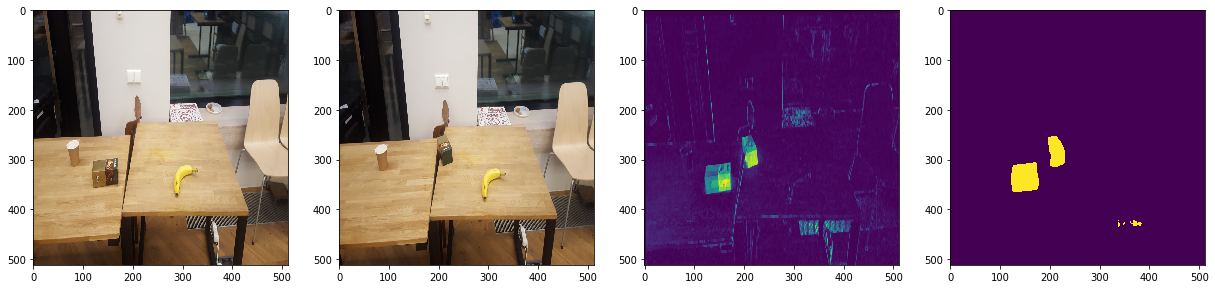

In [121]:
path_1, path_2 = '../input/test/table2/1.jpg', '../input/test/table2/4.jpg'
predict_show(path_1, path_2, 0.8)